<a href="https://colab.research.google.com/github/js-kang02/deeplearning/blob/main/Lecture2_VGG%26InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAT vs Dog Classification (분류)
###1. Simple CNN


> 1) 하이퍼파라미터 설정

> 2) Data & Image preprocessing

> 3) Model 생성 & compile

> 4) Training

> 5) Evaluation & Visualization

###2. VGG 16
###3. Inception V3

### Library Import

In [ ]:
!nvidia-smi

Thu Apr 29 01:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import numpy as np
import os, sys, zipfile
import argparse

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

#### 1) Hyperparmeter 설정

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.img_size = 256
args.batch_size = 20
args.lr = 1e-4
args.epochs = 10
args.decay_rate = 0
args.activation_fn = 'relu'
args.drop_rate = 0.25

#### 2) data download & image preprocessing

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-04-29 01:37:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   143MB/s    in 0.5s    

2021-04-29 01:37:34 (143 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_dogs_dir

'/tmp/cats_and_dogs_filtered/train/dogs'

train 데이터 확인

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.454.jpg', 'cat.156.jpg', 'cat.202.jpg', 'cat.312.jpg', 'cat.609.jpg', 'cat.520.jpg', 'cat.935.jpg', 'cat.109.jpg', 'cat.794.jpg', 'cat.91.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


데이터 시각화

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

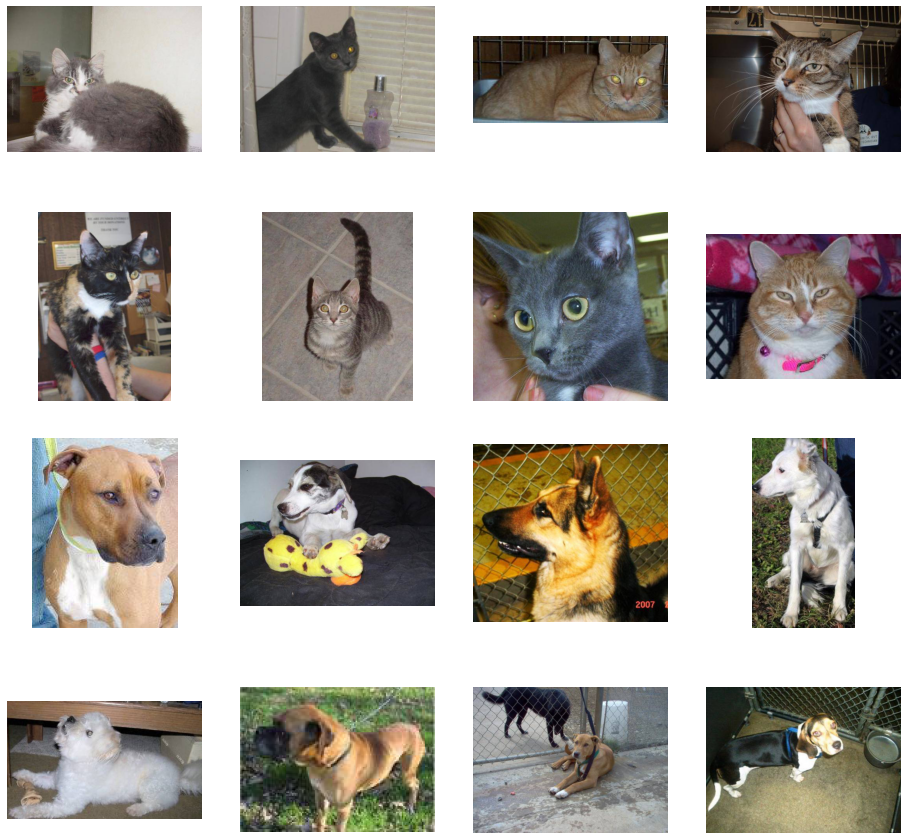

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(args.img_size, args.img_size),  # All images will be resized to 150x150
        batch_size=args.batch_size,
        shuffle=True,
        seed=42,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(args.img_size, args.img_size),
        batch_size=args.batch_size,
        shuffle=False,
        seed=42,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_dir

'/tmp/cats_and_dogs_filtered/train'

#### 3) Model 생성 & Compile

In [ ]:
from tensorflow.keras import layers, Input, Model, activations

In [ ]:
img_input = layers.Input(shape=(args.img_size, args.img_size, 3))

# 1st Convolutional Block
x = layers.Conv2D(filters=16, kernel_size=3, activation=args.activation_fn)(img_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 2nd Convolutional Block
x = layers.Conv2D(32, 3, activation=args.activation_fn)(x)
x = layers.MaxPool2D(2)(x)

# 3nd Convolutional Block
x = layers.Conv2D(64, 3, activation=args.activation_fn)(x)
x = layers.MaxPool2D(2)(x)

In [ ]:
# Flatten Layer
x = layers.Flatten()(x)

# Full-Connected Layer : 분류기
x = layers.Dense(512, activation=args.activation_fn)(x)

output = layers.Dense(1, activation='sigmoid')(x)

# Create Model
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0     

In [ ]:
# Model Compile

from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=args.lr),
              metrics=['acc', tf.keras.metrics.AUC()])

#### 4) Training 시작

In [ ]:
history = model.fit(
                train_generator,
                steps_per_epoch=100, # iteration을 위한 설정 , ex) 2000 images / batch_size = steps
                epochs=args.epochs,
                validation_data = validation_generator,
                validation_steps=50,
                verbose=1
)

Epoch 1/10
100/100 [==============================] - 44s 108ms/step - loss: 0.7043 - acc: 0.5117 - auc: 0.5346 - val_loss: 0.6540 - val_acc: 0.6640 - val_auc: 0.7167
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 0.6375 - acc: 0.6667 - auc: 0.7147 - val_loss: 0.6393 - val_acc: 0.6040 - val_auc: 0.7536
Epoch 3/10
100/100 [==============================] - 10s 105ms/step - loss: 0.5559 - acc: 0.7205 - auc: 0.8040 - val_loss: 0.5811 - val_acc: 0.6870 - val_auc: 0.7680
Epoch 4/10
100/100 [==============================] - 10s 105ms/step - loss: 0.4899 - acc: 0.7606 - auc: 0.8583 - val_loss: 0.5845 - val_acc: 0.6830 - val_auc: 0.7843
Epoch 5/10
100/100 [==============================] - 11s 106ms/step - loss: 0.4355 - acc: 0.8123 - auc: 0.8879 - val_loss: 0.5731 - val_acc: 0.7030 - val_auc: 0.7850
Epoch 6/10
100/100 [==============================] - 11s 106ms/step - loss: 0.3498 - acc: 0.8644 - auc: 0.9424 - val_loss: 0.5708 - val_acc: 0.6990 - val_auc: 0.790

#### 5) Evaluation & Visualization

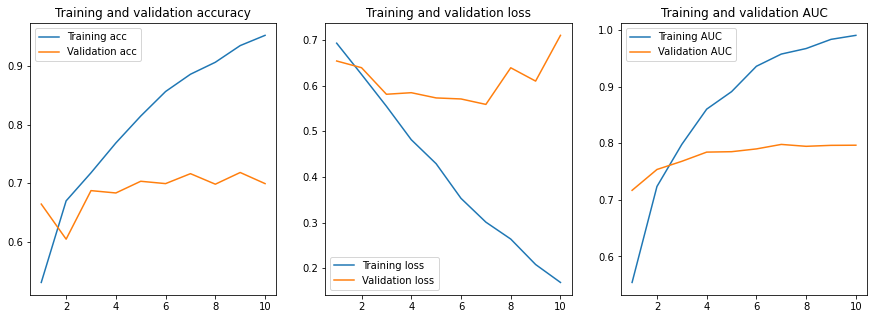

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']
# Get number of epochs
epochs = range(1, (len(acc)+1))

plt.figure(figsize=(15, 5))

# Plot training and validation accuracy per epoch
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Training and validation loss')

plt.subplot(1, 3, 3)
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.legend()
plt.title('Training and validation AUC');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


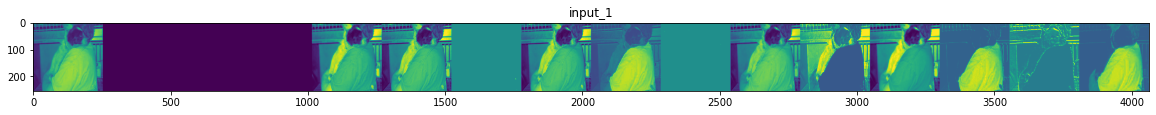

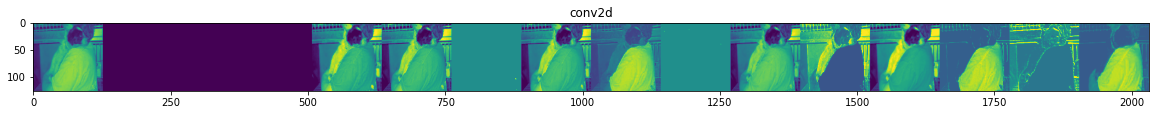

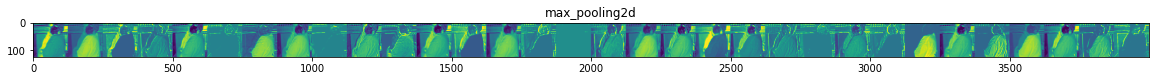

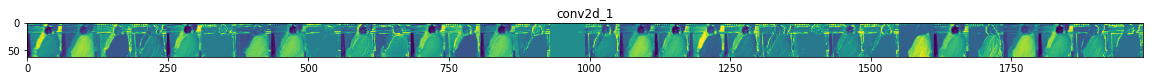

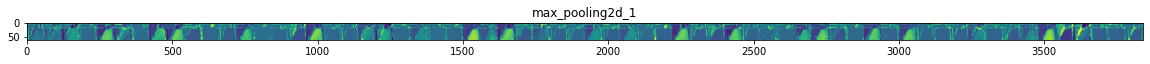

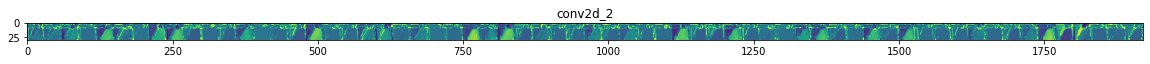

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(args.img_size, args.img_size))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# 2. VGG16

![VGG16](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FK990l%2FbtqwDJ7C54R%2F664Ksm6gyTGBR1wK3YPDFk%2Fimg.png)

![structure](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb1Vk5P%2FbtqwqjujKsa%2FTL2HyQ4kj6pNPz4TsirknK%2Fimg.png)


#### 1) VGG 16 Model 구조

In [ ]:
INIT_FILTERS = 64

In [ ]:
input_layer = Input(shape=(args.img_size, args.img_size, 3))

filters = INIT_FILTERS
l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(input_layer)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.MaxPool2D(strides=(2, 2))(l)

filters *= 2
l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.MaxPool2D(strides=(2, 2))(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.Conv2D(filters=filters, kernel_size=(3, 3), activation=None, padding='same')(l)
l = layers.Activation(args.activation_fn)(l)

l = layers.MaxPool2D(strides=(2, 2))(l)

l = layers.Flatten()(l)
l = layers.Dense(4096, activation = args.activation_fn)(l)
l = layers.Dense(4096, activation = args.activation_fn)(l)
output_layer = layers.Dense(1, activation='sigmoid')(l)

In [ ]:
vgg16= Model(input_layer, output_layer)

vgg16.compile(optimizer=Adam(lr=args.lr),
              loss='binary_crossentropy',
              metrics=['acc', tf.keras.metrics.AUC()])


vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     7385

#### 2) Training 시작 (VGG16)

In [ ]:
history_1 = vgg16.fit(
                train_generator,
                steps_per_epoch=100,
                epochs=args.epochs,
                validation_data = validation_generator,
                validation_steps=50,
                verbose=1
)

Epoch 1/10
100/100 [==============================] - 56s 473ms/step - loss: 0.6938 - acc: 0.5101 - auc_1: 0.4888 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 2/10
100/100 [==============================] - 48s 482ms/step - loss: 0.6933 - acc: 0.5035 - auc_1: 0.4908 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 3/10
100/100 [==============================] - 48s 476ms/step - loss: 0.6932 - acc: 0.5028 - auc_1: 0.4867 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 4/10
100/100 [==============================] - 48s 479ms/step - loss: 0.6931 - acc: 0.5069 - auc_1: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 5/10
100/100 [==============================] - 48s 477ms/step - loss: 0.6931 - acc: 0.5179 - auc_1: 0.4920 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc_1: 0.5000
Epoch 6/10
100/100 [==============================] - 48s 478ms/step - loss: 0.6931 - acc: 0.5065 - auc_1: 0.5000 - val_loss: 0.6931 - val_acc: 0

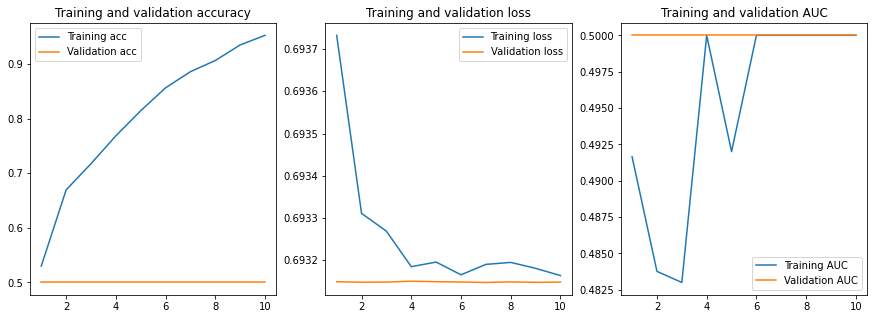

In [ ]:
tacc = history_1.history['acc']
val_acc = history_1.history['val_acc']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

auc = history_1.history['auc_1']
val_auc = history_1.history['val_auc_1']
# Get number of epochs
epochs = range(1, (len(acc)+1))

plt.figure(figsize=(15, 5))

# Plot training and validation accuracy per epoch
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Training and validation loss')

plt.subplot(1, 3, 3)
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.legend()
plt.title('Training and validation AUC');


# 3. Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inception = InceptionV3(weights=None, include_top=True, input_shape=(args.img_size, args.img_size, 3), classes=1, classifier_activation='sigmoid')

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
inception.compile(optimizer=Adam(lr=args.lr),
                  loss='binary_crossentropy',
                  metrics=['acc', tf.keras.metrics.AUC()])

In [ ]:
history_2 = inception.fit(
                train_generator,
                steps_per_epoch=100,
                epochs=args.epochs,
                validation_data = validation_generator,
                validation_steps=50,
                verbose=1
)

Epoch 1/10
100/100 [==============================] - 35s 262ms/step - loss: 0.7525 - acc: 0.5544 - auc_2: 0.5812 - val_loss: 0.7050 - val_acc: 0.5000 - val_auc_2: 0.5674
Epoch 2/10
100/100 [==============================] - 26s 255ms/step - loss: 0.6101 - acc: 0.6624 - auc_2: 0.7265 - val_loss: 0.7332 - val_acc: 0.5000 - val_auc_2: 0.6264
Epoch 3/10
100/100 [==============================] - 26s 259ms/step - loss: 0.5806 - acc: 0.7072 - auc_2: 0.7745 - val_loss: 0.9683 - val_acc: 0.5000 - val_auc_2: 0.6162
Epoch 4/10
100/100 [==============================] - 25s 255ms/step - loss: 0.5148 - acc: 0.7411 - auc_2: 0.8256 - val_loss: 0.9822 - val_acc: 0.5680 - val_auc_2: 0.7098
Epoch 5/10
100/100 [==============================] - 26s 255ms/step - loss: 0.4651 - acc: 0.7749 - auc_2: 0.8616 - val_loss: 0.8088 - val_acc: 0.5940 - val_auc_2: 0.7124
Epoch 6/10
100/100 [==============================] - 26s 256ms/step - loss: 0.4295 - acc: 0.8006 - auc_2: 0.8861 - val_loss: 0.5953 - val_acc: 0

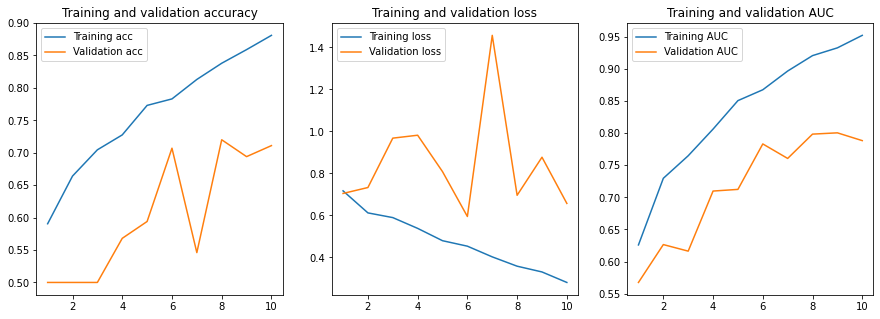

In [ ]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

auc = history_2.history['auc_2']
val_auc = history_2.history['val_auc_2']
# Get number of epochs
epochs = range(1, (len(acc)+1))

plt.figure(figsize=(15, 5))

# Plot training and validation accuracy per epoch
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Training and validation loss')

plt.subplot(1, 3, 3)
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.legend()
plt.title('Training and validation AUC');

In [ ]:
# Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  horizontal_flip=True,
                                  rotation_range=35,
                                  width_shift_range=1.0,
                                  )
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(args.img_size, args.img_size),  # All images will be resized to 150x150
        batch_size=args.batch_size,
        shuffle=True,
        seed=42,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(args.img_size, args.img_size),
        batch_size=args.batch_size,
        shuffle=False,
        seed=42,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
augmented_inception = InceptionV3(weights=None, include_top=True, input_shape=(args.img_size, args.img_size, 3), classes=1, classifier_activation='sigmoid')

In [ ]:
augmented_inception.compile(optimizer=Adam(lr=args.lr),
                        loss='binary_crossentropy',
                        metrics=['acc', tf.keras.metrics.AUC()])

In [ ]:
history_3 = augmented_inception.fit(
                train_generator,
                steps_per_epoch=100,
                epochs=args.epochs,
                validation_data = validation_generator,
                validation_steps=50,
                verbose=1
)

Epoch 1/10
100/100 [==============================] - 44s 384ms/step - loss: 0.7497 - acc: 0.5874 - auc_3: 0.6179 - val_loss: 0.7332 - val_acc: 0.5000 - val_auc_3: 0.5323
Epoch 2/10
100/100 [==============================] - 37s 372ms/step - loss: 0.6313 - acc: 0.6568 - auc_3: 0.7127 - val_loss: 0.6995 - val_acc: 0.4950 - val_auc_3: 0.5353
Epoch 3/10
100/100 [==============================] - 37s 372ms/step - loss: 0.6145 - acc: 0.6738 - auc_3: 0.7305 - val_loss: 0.6848 - val_acc: 0.5530 - val_auc_3: 0.6129
Epoch 4/10
100/100 [==============================] - 37s 366ms/step - loss: 0.5769 - acc: 0.7011 - auc_3: 0.7694 - val_loss: 1.0162 - val_acc: 0.5010 - val_auc_3: 0.6868
Epoch 5/10
100/100 [==============================] - 37s 368ms/step - loss: 0.5658 - acc: 0.6954 - auc_3: 0.7803 - val_loss: 0.6151 - val_acc: 0.6830 - val_auc_3: 0.7435
Epoch 6/10
100/100 [==============================] - 37s 369ms/step - loss: 0.5572 - acc: 0.7238 - auc_3: 0.7905 - val_loss: 0.6334 - val_acc: 0

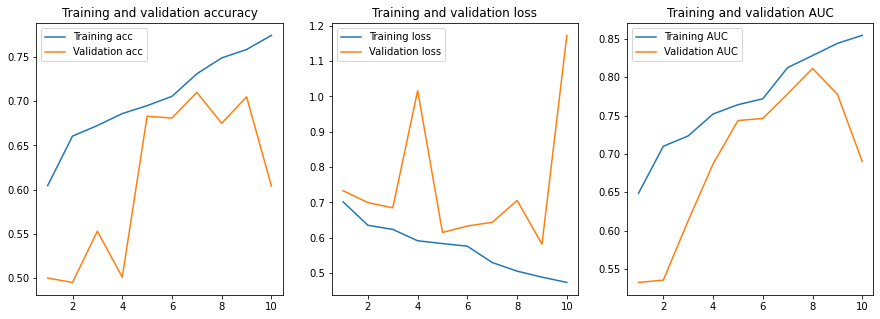

In [ ]:
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

auc = history_3.history['auc_3']
val_auc = history_3.history['val_auc_3']
# Get number of epochs
epochs = range(1, (len(acc)+1))

plt.figure(figsize=(15, 5))

# Plot training and validation accuracy per epoch
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Training and validation loss')

plt.subplot(1, 3, 3)
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.legend()
plt.title('Training and validation AUC');